In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy


C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
at_eur_1h = pd.read_csv('data/indicators_eurusd_1h.csv')

### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## MA decision

In [3]:
at_eur_1h['prev_5MA'] = at_eur_1h['5MA'].shift(1)

at_eur_1h['crossover'] = np.where((at_eur_1h['5MA'] > at_eur_1h['15MA']) & (at_eur_1h['prev_5MA'] < at_eur_1h['15MA']), 'bullish crossover',
                                  np.where((at_eur_1h['5MA'] < at_eur_1h['15MA']) & (at_eur_1h['prev_5MA'] > at_eur_1h['15MA']), 'bearish crossover', None))

at_eur_1h['cross_MA'] = np.where(at_eur_1h['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(at_eur_1h['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))


In [7]:
at_eur_1h['crossover'].value_counts()

crossover
bullish crossover    303
bearish crossover    269
Name: count, dtype: int64

In [5]:
at_eur_1h['cross_MA'].value_counts()

cross_MA
HOLD    4727
BUY      303
SELL     269
Name: count, dtype: int64

In [19]:
at_eur_1h['diff_MA_prev'].describe()

count    5298.000000
mean        0.000007
std         0.002944
min        -0.020712
25%        -0.001129
50%         0.000005
75%         0.001074
max         0.018701
Name: diff_MA_prev, dtype: float64

In [10]:
# Calculating the difference between the shorter and longer average

at_eur_1h['diff_MA'] = at_eur_1h['5MA'] - at_eur_1h['15MA']

# Creation of 1 lagged column with difference in averages
at_eur_1h['diff_MA_prev'] = at_eur_1h['diff_MA'].shift(1)


In [17]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

at_eur_1h['MA_strategy'] = np.where((abs(at_eur_1h['diff_MA']) < 0.0002) & (at_eur_1h['diff_MA_prev'] < 0), 'BUY',
                                  np.where((abs(at_eur_1h['diff_MA']) < 0.0002) & (at_eur_1h['diff_MA_prev'] > 0), 'SELL', 'HOLD'))

In [18]:
at_eur_1h['MA_strategy'].value_counts()

MA_strategy
HOLD    4750
SELL     275
BUY      274
Name: count, dtype: int64

In [16]:
at_eur_1h.tail(6)

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,k_percent,B_MA,BU,BL,prev_5MA,crossover,cross_MA,diff_MA,diff_MA_prev,MA_strategy
5293,67690,EURUSD,1.06770,1.06886,1.06927,1.06748,0.0,2023-11-13 15:00:00.000,1h,EURUSD,...,57.739558,1.069615,1.078425,1.060805,1.068488,None,HOLD,-0.001562,-0.001529,HOLD
5294,67712,EURUSD,1.06960,1.07016,1.07051,1.06901,0.0,2023-11-13 18:00:00.000,1h,EURUSD,...,89.680590,1.069726,1.078503,1.060949,1.068468,None,HOLD,-0.000080,-0.001562,BUY
5295,67702,EURUSD,1.06991,1.06957,1.07061,1.06936,0.0,2023-11-13 17:00:00.000,1h,EURUSD,...,74.634146,1.069785,1.078540,1.061030,1.068754,bullish crossover,BUY,0.000353,-0.000080,HOLD
5296,67682,EURUSD,1.06730,1.06769,1.06801,1.06679,0.0,2023-11-13 14:00:00.000,1h,EURUSD,...,28.780488,1.069747,1.078533,1.060960,1.069208,None,HOLD,0.000480,0.000353,HOLD
5297,67698,EURUSD,1.06888,1.06992,1.07038,1.06852,0.0,2023-11-13 16:00:00.000,1h,EURUSD,...,83.170732,1.069823,1.078586,1.061060,1.069292,None,HOLD,0.000338,0.000480,HOLD
5298,67724,EURUSD,1.07018,1.06991,1.07043,1.06991,0.0,2023-11-13 20:00:00.000,1h,EURUSD,...,82.926829,1.069885,1.078631,1.061139,1.069240,None,HOLD,0.000497,0.000338,HOLD


In [20]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [0, 1.], [0.0002, 0.]], term="low")
S2 = sf.FuzzySet(points=[[0, 0.], [0.0002, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)

# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS SELL)"
FS.add_rules([R1, R2])

at_eur_1h['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", at_eur_1h.loc[at_eur_1h.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'fuzz_MA_strategy'] = 'BUY'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'fuzz_MA_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



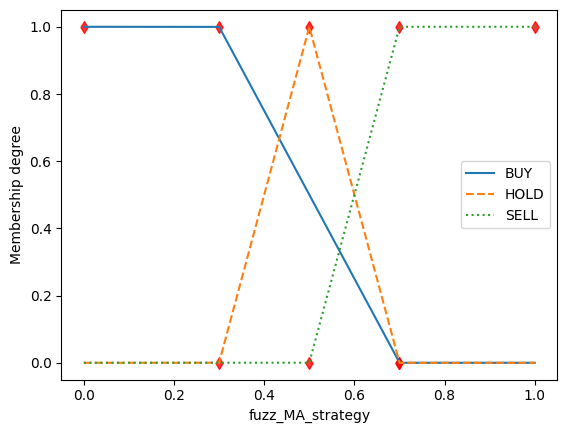

In [29]:
FS.plot_variable('fuzz_MA_strategy')

In [22]:
at_eur_1h['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
BUY     2675
SELL    2437
HOLD     187
Name: count, dtype: int64

## Backtesting

### ========

[Backtesting on github](https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py#L1014)
### ========

     `cash` is the initial cash to start with.

        `commission` is the commission ratio. E.g. if your broker's commission
        is 1% of trade value, set commission to `0.01`. Note, if you wish to
        account for bid-ask spread, you can approximate doing so by increasing
        the commission, e.g. set it to `0.0002` for commission-less forex
        trading where the average spread is roughly 0.2‰ of asking price.

        `margin` is the required margin (ratio) of a leveraged account.
        No difference is made between initial and maintenance margins.
        To run the backtest using e.g. 50:1 leverge that your broker allows,
        set margin to `0.02` (1 / leverage).

        If `trade_on_close` is `True`, market orders will be filled
        with respect to the current bar's closing price instead of the
        next bar's open.

        If `hedging` is `True`, allow trades in both directions simultaneously.
        If `False`, the opposite-facing orders first close existing trades in
        a [FIFO] manner.

        If `exclusive_orders` is `True`, each new order auto-closes the previous
        trade/position, making at most a single trade (long or short) in effect
        at each time.


In [43]:
at_eur_1h.tail()

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,26Ewm,MACD,low_14,high_14,k_percent,B_MA,BU,BL,dec_rsi,Signal_RSI_fuzz_system
5294,67712,EURUSD,1.06960,1.07016,1.07051,1.06901,0.0,2023-11-13 18:00:00.000,1h,EURUSD,...,1.069200,-0.000069,1.06651,1.07058,89.680590,1.069726,1.078503,1.060949,HOLD,HOLD
5295,67702,EURUSD,1.06991,1.06957,1.07061,1.06936,0.0,2023-11-13 17:00:00.000,1h,EURUSD,...,1.069227,-0.000029,1.06651,1.07061,74.634146,1.069785,1.078540,1.061030,HOLD,HOLD
5296,67682,EURUSD,1.06730,1.06769,1.06801,1.06679,0.0,2023-11-13 14:00:00.000,1h,EURUSD,...,1.069114,-0.000147,1.06651,1.07061,28.780488,1.069747,1.078533,1.060960,HOLD,HOLD
5297,67698,EURUSD,1.06888,1.06992,1.07038,1.06852,0.0,2023-11-13 16:00:00.000,1h,EURUSD,...,1.069173,-0.000060,1.06651,1.07061,83.170732,1.069823,1.078586,1.061060,HOLD,HOLD
5298,67724,EURUSD,1.07018,1.06991,1.07043,1.06991,0.0,2023-11-13 20:00:00.000,1h,EURUSD,...,1.069228,0.000008,1.06651,1.07061,82.926829,1.069885,1.078631,1.061139,HOLD,HOLD


## Fuzzy

In [30]:
at_eur_1h['data_datetime'] = pd.to_datetime(at_eur_1h['data_datetime'])
at_eur_1h = at_eur_1h.set_index('data_datetime')

KeyError: 'data_datetime'

In [31]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['fuzz_MA_strategy'] == 'BUY', 
                        at_eur_1h['fuzz_MA_strategy'] == 'SELL')

bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
stats = bt.run()
bt.plot()


C:\Users\Karolina\AppData\Local\Temp\ipykernel_17264\4114997875.py:7: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p2784', ...)

In [32]:
stats

Start                     2023-01-05 09:00:00
End                       2023-11-21 11:00:00
Duration                    320 days 02:00:00
Exposure Time [%]                   56.652199
Equity Final [$]                  9971.090653
Equity Peak [$]                       10000.0
Return [%]                          -0.289093
Buy & Hold Return [%]                1.754957
Return (Ann.) [%]                   -0.271858
Volatility (Ann.) [%]                0.011615
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.289093
Avg. Drawdown [%]                   -0.289093
Max. Drawdown Duration      308 days 03:00:00
Avg. Drawdown Duration      308 days 03:00:00
# Trades                                 2674
Win Rate [%]                              0.0
Best Trade [%]                      -0.365815
Worst Trade [%]                     -1.826955
Avg. Trade [%]                    

## Sharp

In [12]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['dec_rsi'] == 'BUY', 
                        at_eur_1h['dec_rsi'] == 'SELL')

bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_2152\3263418944.py:7: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


Start                     2023-01-05 09:00:00
End                       2023-11-21 11:00:00
Duration                    320 days 02:00:00
Exposure Time [%]                   48.952633
Equity Final [$]                  9993.409937
Equity Peak [$]                       10000.0
Return [%]                          -0.065901
Buy & Hold Return [%]                1.754957
Return (Ann.) [%]                   -0.061967
Volatility (Ann.) [%]                0.006525
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.065902
Avg. Drawdown [%]                   -0.065902
Max. Drawdown Duration      308 days 00:00:00
Avg. Drawdown Duration      308 days 00:00:00
# Trades                                  609
Win Rate [%]                              0.0
Best Trade [%]                      -0.062574
Worst Trade [%]                     -1.838173
Avg. Trade [%]                    

## Przykład backtesting + funkcje z biblioteki

In [60]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()


C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p16443', ...)

In [ ]:
stats

In [ ]:
def run(self, **kwargs) -> pd.Series:
        """
        Run the backtest. Returns `pd.Series` with results and statistics.

        Keyword arguments are interpreted as strategy parameters.

            >>> Backtest(GOOG, SmaCross).run()
            Start                     2004-08-19 00:00:00
            End                       2013-03-01 00:00:00
            Duration                   3116 days 00:00:00
            Exposure Time [%]                     93.9944
            Equity Final [$]                      51959.9
            Equity Peak [$]                       75787.4
            Return [%]                            419.599
            Buy & Hold Return [%]                 703.458
            Return (Ann.) [%]                      21.328
            Volatility (Ann.) [%]                 36.5383
            Sharpe Ratio                         0.583718
            Sortino Ratio                         1.09239
            Calmar Ratio                         0.444518
            Max. Drawdown [%]                    -47.9801
            Avg. Drawdown [%]                    -5.92585
            Max. Drawdown Duration      584 days 00:00:00
            Avg. Drawdown Duration       41 days 00:00:00
            # Trades                                   65
            Win Rate [%]                          46.1538
            Best Trade [%]                         53.596
            Worst Trade [%]                      -18.3989
            Avg. Trade [%]                        2.35371
            Max. Trade Duration         183 days 00:00:00
            Avg. Trade Duration          46 days 00:00:00
            Profit Factor                         2.08802
            Expectancy [%]                        8.79171
            SQN                                  0.916893
            Kelly Criterion                        0.6134
            _strategy                            SmaCross
            _equity_curve                           Eq...
            _trades                       Size  EntryB...
            dtype: object

        .. warning::
            You may obtain different results for different strategy parameters.
            E.g. if you use 50- and 200-bar SMA, the trading simulation will
            begin on bar 201. The actual length of delay is equal to the lookback
            period of the `Strategy.I` indicator which lags the most.
            Obviously, this can affect results.
        """
        data = _Data(self._data.copy(deep=False))
        broker: _Broker = self._broker(data=data)
        strategy: Strategy = self._strategy(broker, data, kwargs)

        strategy.init()
        data._update()  # Strategy.init might have changed/added to data.df

        # Indicators used in Strategy.next()
        indicator_attrs = {attr: indicator
                           for attr, indicator in strategy.__dict__.items()
                           if isinstance(indicator, _Indicator)}.items()

        # Skip first few candles where indicators are still "warming up"
        # +1 to have at least two entries available
        start = 1 + max((np.isnan(indicator.astype(float)).argmin(axis=-1).max()
                         for _, indicator in indicator_attrs), default=0)

        # Disable "invalid value encountered in ..." warnings. Comparison
        # np.nan >= 3 is not invalid; it's False.
        with np.errstate(invalid='ignore'):

            for i in range(start, len(self._data)):
                # Prepare data and indicators for `next` call
                data._set_length(i + 1)
                for attr, indicator in indicator_attrs:
                    # Slice indicator on the last dimension (case of 2d indicator)
                    setattr(strategy, attr, indicator[..., :i + 1])

                # Handle orders processing and broker stuff
                try:
                    broker.next()
                except _OutOfMoneyError:
                    break

                # Next tick, a moment before bar close
                strategy.next()
            else:
                # Close any remaining open trades so they produce some stats
                for trade in broker.trades:
                    trade.close()

                # Re-run broker one last time to handle orders placed in the last strategy
                # iteration. Use the same OHLC values as in the last broker iteration.
                if start < len(self._data):
                    try_(broker.next, exception=_OutOfMoneyError)

            # Set data back to full length
            # for future `indicator._opts['data'].index` calls to work
            data._set_length(len(self._data))

            equity = pd.Series(broker._equity).bfill().fillna(broker._cash).values
            self._results = compute_stats(
                trades=broker.closed_trades,
                equity=equity,
                ohlc_data=self._data,
                risk_free_rate=0.0,
                strategy_instance=strategy,
            )

        return self._results

In [ ]:
class SignalStrategy(Strategy):
    """
    A simple helper strategy that operates on position entry/exit signals.
    This makes the backtest of the strategy simulate a [vectorized backtest].
    See [tutorials] for usage examples.

    [vectorized backtest]: https://www.google.com/search?q=vectorized+backtest
    [tutorials]: index.html#tutorials

    To use this helper strategy, subclass it, override its
    `backtesting.backtesting.Strategy.init` method,
    and set the signal vector by calling
    `backtesting.lib.SignalStrategy.set_signal` method from within it.

        class ExampleStrategy(SignalStrategy):
            def init(self):
                super().init()
                self.set_signal(sma1 > sma2, sma1 < sma2)

    Remember to call `super().init()` and `super().next()` in your
    overridden methods.
    """
    __entry_signal = (0,)
    __exit_signal = (False,)

    def set_signal(self, entry_size: Sequence[float],
                   exit_portion: Optional[Sequence[float]] = None,
                   *,
                   plot: bool = True):
        """
        Set entry/exit signal vectors (arrays).

        A long entry signal is considered present wherever `entry_size`
        is greater than zero, and a short signal wherever `entry_size`
        is less than zero, following `backtesting.backtesting.Order.size` semantics.

        If `exit_portion` is provided, a nonzero value closes portion the position
        (see `backtesting.backtesting.Trade.close()`) in the respective direction
        (positive values close long trades, negative short).

        If `plot` is `True`, the signal entry/exit indicators are plotted when
        `backtesting.backtesting.Backtest.plot` is called.
        """
        self.__entry_signal = self.I(  # type: ignore
            lambda: pd.Series(entry_size, dtype=float).replace(0, np.nan),
            name='entry size', plot=plot, overlay=False, scatter=True, color='black')

        if exit_portion is not None:
            self.__exit_signal = self.I(  # type: ignore
                lambda: pd.Series(exit_portion, dtype=float).replace(0, np.nan),
                name='exit portion', plot=plot, overlay=False, scatter=True, color='black')

    def next(self):
        super().next()

        exit_portion = self.__exit_signal[-1]
        if exit_portion > 0:
            for trade in self.trades:
                if trade.is_long:
                    trade.close(exit_portion)
        elif exit_portion < 0:
            for trade in self.trades:
                if trade.is_short:
                    trade.close(-exit_portion)

        entry_size = self.__entry_signal[-1]
        if entry_size > 0:
            self.buy(size=entry_size)
        elif entry_size < 0:
            self.sell(size=-entry_size)


In [ ]:
class TrailingStrategy(Strategy):
    """
    A strategy with automatic trailing stop-loss, trailing the current
    price at distance of some multiple of average true range (ATR). Call
    `TrailingStrategy.set_trailing_sl()` to set said multiple
    (`6` by default). See [tutorials] for usage examples.

    [tutorials]: index.html#tutorials

    Remember to call `super().init()` and `super().next()` in your
    overridden methods.
    """
    __n_atr = 6.
    __atr = None

    def init(self):
        super().init()
        self.set_atr_periods()

    def set_atr_periods(self, periods: int = 100):
        """
        Set the lookback period for computing ATR. The default value
        of 100 ensures a _stable_ ATR.
        """
        hi, lo, c_prev = self.data.High, self.data.Low, pd.Series(self.data.Close).shift(1)
        tr = np.max([hi - lo, (c_prev - hi).abs(), (c_prev - lo).abs()], axis=0)
        atr = pd.Series(tr).rolling(periods).mean().bfill().values
        self.__atr = atr

    def set_trailing_sl(self, n_atr: float = 6):
        """
        Sets the future trailing stop-loss as some multiple (`n_atr`)
        average true bar ranges away from the current price.
        """
        self.__n_atr = n_atr

    def next(self):
        super().next()
        # Can't use index=-1 because self.__atr is not an Indicator type
        index = len(self.data)-1
        for trade in self.trades:
            if trade.is_long:
                trade.sl = max(trade.sl or -np.inf,
                               self.data.Close[index] - self.__atr[index] * self.__n_atr)
            else:
                trade.sl = min(trade.sl or np.inf,
                               self.data.Close[index] + self.__atr[index] * self.__n_atr)


# Prevent pdoc3 documenting __init__ signature of Strategy subclasses
for cls in list(globals().values()):
    if isinstance(cls, type) and issubclass(cls, Strategy):
        __pdoc__[f'{cls.__name__}.__init__'] = False


# NOTE: Don't put anything below this __all__ list

__all__ = [getattr(v, '__name__', k)
           for k, v in globals().items()                        # export
           if ((callable(v) and v.__module__ == __name__ or     # callables from this module
                k.isupper()) and                                # or CONSTANTS
               not getattr(v, '__name__', k).startswith('_'))]  # neither marked internal

In [ ]:
def plot(*, results: pd.Series,
         df: pd.DataFrame,
         indicators: List[_Indicator],
         filename='', plot_width=None,
         plot_equity=True, plot_return=False, plot_pl=True,
         plot_volume=True, plot_drawdown=False, plot_trades=True,
         smooth_equity=False, relative_equity=True,
         superimpose=True, resample=True,
         reverse_indicators=True,
         show_legend=True, open_browser=True):
    """
    Like much of GUI code everywhere, this is a mess.
    """
    # We need to reset global Bokeh state, otherwise subsequent runs of
    # plot() contain some previous run's cruft data (was noticed when
    # TestPlot.test_file_size() test was failing).
    if not filename and not IS_JUPYTER_NOTEBOOK:
        filename = _windos_safe_filename(str(results._strategy))
    _bokeh_reset(filename)

    COLORS = [BEAR_COLOR, BULL_COLOR]
    BAR_WIDTH = .8

    assert df.index.equals(results['_equity_curve'].index)
    equity_data = results['_equity_curve'].copy(deep=False)
    trades = results['_trades']

    plot_volume = plot_volume and not df.Volume.isnull().all()
    plot_equity = plot_equity and not trades.empty
    plot_return = plot_return and not trades.empty
    plot_pl = plot_pl and not trades.empty
    is_datetime_index = isinstance(df.index, pd.DatetimeIndex)

    from .lib import OHLCV_AGG
    # ohlc df may contain many columns. We're only interested in, and pass on to Bokeh, these
    df = df[list(OHLCV_AGG.keys())].copy(deep=False)

    # Limit data to max_candles
    if is_datetime_index:
        df, indicators, equity_data, trades = _maybe_resample_data(
            resample, df, indicators, equity_data, trades)

    df.index.name = None  # Provides source name @index
    df['datetime'] = df.index  # Save original, maybe datetime index
    df = df.reset_index(drop=True)
    equity_data = equity_data.reset_index(drop=True)
    index = df.index

    new_bokeh_figure = partial(
        _figure,
        x_axis_type='linear',
        width=plot_width,
        height=400,
        tools="xpan,xwheel_zoom,box_zoom,undo,redo,reset,save",
        active_drag='xpan',
        active_scroll='xwheel_zoom')

    pad = (index[-1] - index[0]) / 20

    _kwargs = dict(x_range=Range1d(index[0], index[-1],
                                   min_interval=10,
                                   bounds=(index[0] - pad,
                                           index[-1] + pad))) if index.size > 1 else {}
    fig_ohlc = new_bokeh_figure(**_kwargs)
    figs_above_ohlc, figs_below_ohlc = [], []

    source = ColumnDataSource(df)
    source.add((df.Close >= df.Open).values.astype(np.uint8).astype(str), 'inc')

    trade_source = ColumnDataSource(dict(
        index=trades['ExitBar'],
        datetime=trades['ExitTime'],
        exit_price=trades['ExitPrice'],
        size=trades['Size'],
        returns_positive=(trades['ReturnPct'] > 0).astype(int).astype(str),
    ))

    inc_cmap = factor_cmap('inc', COLORS, ['0', '1'])
    cmap = factor_cmap('returns_positive', COLORS, ['0', '1'])
    colors_darker = [lightness(BEAR_COLOR, .35),
                     lightness(BULL_COLOR, .35)]
    trades_cmap = factor_cmap('returns_positive', colors_darker, ['0', '1'])

    if is_datetime_index:
        fig_ohlc.xaxis.formatter = CustomJSTickFormatter(
            args=dict(axis=fig_ohlc.xaxis[0],
                      formatter=DatetimeTickFormatter(days='%a, %d %b',
                                                      months='%m/%Y'),
                      source=source),
            code='''
this.labels = this.labels || formatter.doFormat(ticks
                                                .map(i => source.data.datetime[i])
                                                .filter(t => t !== undefined));
return this.labels[index] || "";
        ''')

    NBSP = '\N{NBSP}' * 4  # noqa: E999
    ohlc_extreme_values = df[['High', 'Low']].copy(deep=False)
    ohlc_tooltips = [
        ('x, y', NBSP.join(('$index',
                            '$y{0,0.0[0000]}'))),
        ('OHLC', NBSP.join(('@Open{0,0.0[0000]}',
                            '@High{0,0.0[0000]}',
                            '@Low{0,0.0[0000]}',
                            '@Close{0,0.0[0000]}'))),
        ('Volume', '@Volume{0,0}')]


In [11]:
# Zbliżone do ostregoo

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [31, 0.]], term="low")
S2 = sf.FuzzySet(points=[[31, 1.], [50, 1.], [69, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[69, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.5, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [12]:
at_eur_1h['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    4099
BUY      618
SELL     582
Name: count, dtype: int64

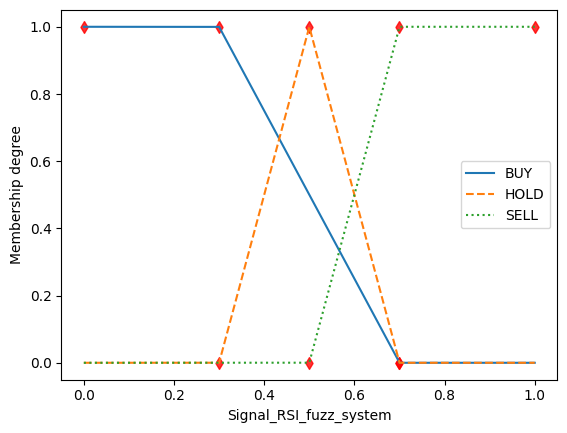

In [20]:
FS.plot_variable('Signal_RSI_fuzz_system')

dec_rsi
HOLD    4131
BUY      610
SELL     558
Name: count, dtype: int64